# Hypothesis Tests: Translating Resampling Work into `scipy.stats`

Pair each simulation-based analysis with a closed-form approximation so you can tell both stories for the same question.

## How to use this notebook
- Work through the tasks in order and duplicate sections if you need more space. The README has more guidance.
- Keep large/raw data out of Git; load it from your local data directory.
- Replace the placeholder code cells with working code, then summarize findings in the surrounding markdown.
- When finished, restart the kernel, run all cells, and double-check that everything executes cleanly.

## Frequentist toolbox reminder
You may find these patterns handy when translating permutation work into CLT-style stats:
- `scipy.stats`: `ttest_ind`, `ttest_rel`, `norm`, `t`, `binomtest`, `chi2`.
- Standard errors: `sample_std / np.sqrt(n)` for means, `np.sqrt(p * (1 - p) / n)` for proportions.
- `statsmodels.stats.proportion.proportion_confint` for Wald/score intervals on proportions.
- `scipy.stats.sem` or `DescrStatsW` for weighted summaries.
- Use `stats.norm.cdf` / `ppf` for quick p-values or critical values when assumptions are reasonable.

## Getting Started
Duplicate or remove task sections as needed.

### Imports

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

### Data loading
Point these at the datasets you need for the tasks below.

In [45]:
# Example:
car_listings = pd.read_csv('car_listings.zip')



## Task 1

If this task is going to be a hypothesis test, briefly describe the hypothesis and dataset. If this task is going to be the calculation of an uncertainty, describe the metric and data. If this is the uncertainty calculation where you'll choose an additional metric other than the mean or a proportion, describe that metric as well.

Filter to Ford F-150s from Duluth and Minneapolis, clean prices, and test whether Duluth’s mean asking price exceeds Minneapolis using a difference-in-means statistic with permutation resampling.


### Computational Approach

Briefly describe the resampling or permutation workflow you'll use.

In [46]:
car_listings.head()

,url,location,post_id,time_posted,name,make,model,year,odometer,title,...,type,transmission,condition,vin,price,posting_body_text,title_text,num_images,latitude,longitude
0,https://fargo.craigslist.org/cto/d/west-fargo-...,fargo,7787882335,2024-09-25 09:35:39+00:00,chevy equinox lt awd,chevrolet,equinox,2013.0,160000.0,clean,...,SUV,automatic,NaN,NaN,6000.0,\n\nQR Code Link to This Post\n\n\n14 Equinox ...,14 Chevy Equinox,11.0,46.890700,-96.925800
1,https://chicago.craigslist.org/nwc/cto/d/des-p...,chicago,7789338453,2024-09-30 12:25:28+00:00,ford transit,ford,transit 250 van,2019.0,93000.0,clean,...,van,automatic,good,NaN,21900.0,\n\nQR Code Link to This Post\n\n\n2019 Ford C...,2019 FORD TRANSIT 250 VAN,14.0,42.023580,-87.902577
2,https://chicago.craigslist.org/nch/cto/d/evans...,chicago,7789384937,2024-09-30 14:33:58+00:00,ford escape titanium,ford,escape,2014.0,122000.0,clean,...,SUV,automatic,excellent,NaN,6250.0,\n\nQR Code Link to This Post\n\n\n2014 Ford E...,2014 Ford Escape (Excellent condition) Titaniu...,12.0,42.052098,-87.686005
3,https://chicago.craigslist.org/sox/cto/d/chica...,chicago,7789321782,2024-09-30 11:42:21+00:00,nissan altima 2.5 s,nissan,altima,2015.0,145000.0,clean,...,sedan,automatic,excellent,NaN,5200.0,\n\nQR Code Link to This Post\n\n\nHeres is my...,"2015 Nissan Altima S, 145k, *Remote Start*, 4 ...",11.0,41.781400,-87.770500
4,https://chicago.craigslist.org/nwi/cto/d/scher...,chicago,7789402919,2024-09-30 15:25:31+00:00,honda odyssey touring,honda,odyssey,2007.0,230000.0,clean,...,minivan,automatic,excellent,NaN,3500.0,\n\nQR Code Link to This Post\n\n\nVery Nice V...,2007 Honda Odyssey Touring,10.0,41.492200,-87.460500


In [47]:
# All strings in lowercase.
car_listings=car_listings.applymap(
    lambda x: x.lower().strip() if isinstance(x, str)
    else x )

In [48]:
# Drop duplicates from `dcar_listingsf` 
car_listings.drop_duplicates()

,url,location,post_id,time_posted,name,make,model,year,odometer,title,...,type,transmission,condition,vin,price,posting_body_text,title_text,num_images,latitude,longitude
0,https://fargo.craigslist.org/cto/d/west-fargo-...,fargo,7787882335,2024-09-25 09:35:39+00:00,chevy equinox lt awd,chevrolet,equinox,2013.0,160000.0,clean,...,suv,automatic,NaN,NaN,6000.0,qr code link to this post\n\n\n14 equinox \nal...,14 chevy equinox,11.0,46.890700,-96.925800
1,https://chicago.craigslist.org/nwc/cto/d/des-p...,chicago,7789338453,2024-09-30 12:25:28+00:00,ford transit,ford,transit 250 van,2019.0,93000.0,clean,...,van,automatic,good,NaN,21900.0,qr code link to this post\n\n\n2019 ford cargo...,2019 ford transit 250 van,14.0,42.023580,-87.902577
2,https://chicago.craigslist.org/nch/cto/d/evans...,chicago,7789384937,2024-09-30 14:33:58+00:00,ford escape titanium,ford,escape,2014.0,122000.0,clean,...,suv,automatic,excellent,NaN,6250.0,qr code link to this post\n\n\n2014 ford escap...,2014 ford escape (excellent condition) titaniu...,12.0,42.052098,-87.686005
3,https://chicago.craigslist.org/sox/cto/d/chica...,chicago,7789321782,2024-09-30 11:42:21+00:00,nissan altima 2.5 s,nissan,altima,2015.0,145000.0,clean,...,sedan,automatic,excellent,NaN,5200.0,qr code link to this post\n\n\nheres is my 201...,"2015 nissan altima s, 145k, *remote start*, 4 ...",11.0,41.781400,-87.770500
4,https://chicago.craigslist.org/nwi/cto/d/scher...,chicago,7789402919,2024-09-30 15:25:31+00:00,honda odyssey touring,honda,odyssey,2007.0,230000.0,clean,...,minivan,automatic,excellent,NaN,3500.0,qr code link to this post\n\n\nvery nice van r...,2007 honda odyssey touring,10.0,41.492200,-87.460500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266811,https://chicago.craigslist.org/nwc/cto/d/verno...,chicago,7777942459,2024-08-22 14:24:46+00:00,chevrolet express 1500 cargo,chevrolet,express 1500 cargo,2014.0,352622.0,missing,...,van,automatic,fair,1gcsgafx0e1110269,1200.0,qr code link to this post\n\n\nchevy express v...,2014 chevrolet express 1500,13.0,42.246220,-87.972255
266812,https://chicago.craigslist.org/sox/cto/d/chica...,chicago,7786558715,2024-09-20 14:39:58+00:00,ford ranger regular cab,ford,ranger regular cab,2006.0,205620.0,clean,...,pickup,manual,NaN,1ftyr10d36pa63952,1500.0,qr code link to this post\n\n\n2006 ford range...,2006 ford ranger xl,12.0,41.793532,-87.703752
266813,https://chicago.craigslist.org/chc/cto/d/frank...,chicago,7765750127,2024-07-13 07:05:20+00:00,jeep wrangler unlimited,jeep,wrangler unlimited,2006.0,51800.0,clean,...,offroad,automatic,excellent,NaN,23000.0,qr code link to this post\n\n\n2006 jeep wrang...,2006 jeep wrangler unlimited 51k miles auto clean,23.0,41.509400,-87.824800
266814,https://chicago.craigslist.org/nwc/cto/d/liber...,chicago,7754969164,2024-06-08 07:08:13+00:00,jeep wrangler unlimited rubicon,jeep,wrangler unlimited,2010.0,124000.0,clean,...,NaN,automatic,good,NaN,15900.0,qr code link to this post\n\n\n2010 jeep wrang...,2010 jeep wrangler rubicon 4 dr,19.0,42.281000,-87.950000


In [49]:
car_listings_F150 = car_listings[(car_listings['make'] == 'ford') & (car_listings['model'] == 'f150')]

mpls_f150_price = car_listings_F150[car_listings_F150['location'] == 'minneapolis']['price'].dropna()
duluth_f150_price = car_listings_F150[car_listings_F150['location'] == 'duluth']['price'].dropna()

mpls_F150_sample = mpls_f150_price.sample(50, random_state=42)
duluth_f150_sample = duluth_f150_price.sample(50, random_state=42)

In [76]:
diff_means = []
n = 1_000  

for i in range(n):
    mpls_sample = np.random.choice(
        mpls_f150_price,
        size=len(mpls_f150_price),
        replace=True
    )
    
    duluth_sample = np.random.choice(
        duluth_f150_price,
        size=len(duluth_f150_price),
        replace=True
    )
    
    diff = np.mean(mpls_sample) - np.mean(duluth_sample)
    diff_means.append(diff)

# One-sided p-value
p_value = np.mean(np.array(diff_means) >= obs_diff)

p_value


0.0

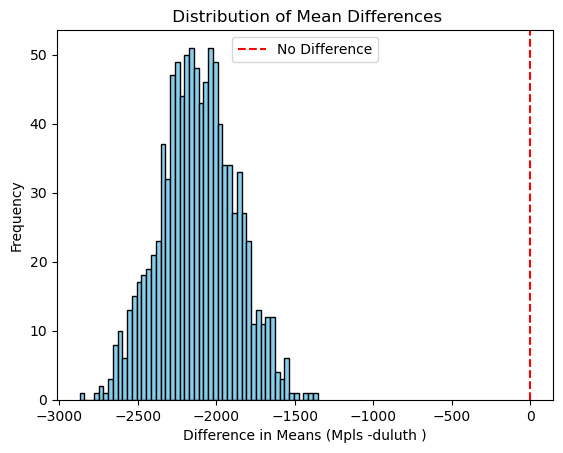

In [79]:
plt.hist(diff_means, bins=50, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='No Difference')
plt.xlabel('Difference in Means (Mpls -duluth )')
plt.ylabel('Frequency')
plt.title(' Distribution of Mean Differences')
plt.legend()
plt.show()

### CLT Approach

Summarize how you'll approximate the sampling distribution analytically (e.g., using SE formulas).

In [80]:
import numpy as np
from scipy import stats

# Sample sizes
n_d = len(duluth_f150_price)
n_m = len(mpls_f150_price)

# Sample means
mean_d = np.mean(duluth_f150_price)
mean_m = np.mean(mpls_f150_price)

# Sample variances
var_d = np.var(duluth_f150_price, ddof=1)
var_m = np.var(mpls_f150_price, ddof=1)

# Standard error (CLT)
se = np.sqrt(var_d / n_d + var_m / n_m)

# t-statistic
t_stat = (mean_d - mean_m) / se

# Welch–Satterthwaite degrees of freedom
df = (
    (var_d / n_d + var_m / n_m) ** 2 /
    ((var_d / n_d) ** 2 / (n_d - 1) + (var_m / n_m) ** 2 / (n_m - 1))
)

# One-sided p-value (Duluth > Minneapolis)
p_value = 1 - stats.t.cdf(t_stat, df)

mean_d, mean_m, t_stat, df, p_value


(13743.562310030395,
 10370.702214452214,
 3.888217105812479,
 385.2543994790485,
 5.9452820568850484e-05)

### Comparison

Discuss how the computational and CLT approaches align or diverge.

Both permutation and CLT p-values are very simular meaning they lead to the same inferencial conclusion. With an p-value close to 0 for both test, there is strong statistcal evidence that Duluth's asking price for ford F-15 is higher than Minneapolis. 

## Task 2

If this task is going to be a hypothesis test, briefly describe the hypothesis and dataset. If this task is going to be the calculation of an uncertainty, describe the metric and data. If this is the uncertainty calculation where you'll choose an additional metric other than the mean or a proportion, describe that metric as well.

### Computational Approach

Outline the resampling or permutation workflow you'll use.

Hypothesis Test	Compute progressivism scores and test whether a target region’s mean differs from the rest using bootstrap differences (or permutation) to form the reference distribution.

In [53]:
wsecu_survey_data= pd.read_csv('wsecu_survey_data.txt', sep='\t')

wsecu_survey_data.head()

,Unnamed: 0,id,age,gender,engagement,mem.edu,zip,channel,harm,fair,in.group,authority,purity,account.age,region,public.sector,sustainability,localism,main.focal.value,support.of.focal.value
0,0,346,56,other,Engaged,2,98503.0,Branch,1.00,1.00,1.00,1.00,1.25,9.951,Thurston,yes,2.333333,2.75,Homelessness,0.000000
1,1,348,66,female,Highly Engaged,3,98012.0,Branch,5.00,4.75,2.25,3.25,2.25,8.838,W WA Metro,yes,6.000000,5.75,Environment,18.627830
2,2,349,71,male,Not Engaged,7,98506.0,Branch,3.25,4.25,2.25,3.25,2.75,5.356,Thurston,yes,5.166667,4.50,Hunger/Poverty,28.739986
3,3,352,66,male,Engaged,7,NaN,Branch,4.25,4.75,4.75,3.25,3.75,9.192,W WA Metro,no,5.500000,4.50,Education,18.055372
4,4,358,50,male,Highly Engaged,4,98233.0,Branch,2.00,4.50,3.50,4.50,3.25,11.570,W WA Non Metro,yes,2.833333,4.00,Education,4.400921


In [54]:
# Compute progressivism score
wsecu_survey_data['progressivism'] = (
    wsecu_survey_data[['harm', 'fair']].mean(axis=1) -
    wsecu_survey_data[['purity','in.group','authority']].mean(axis=1)
)
target_region = "Thurston"

target = wsecu_survey_data[wsecu_survey_data['region'] == target_region]['progressivism']
others = wsecu_survey_data[wsecu_survey_data['region'] != target_region]['progressivism']
observed_diff = target.mean() - others.mean()
observed_diff

n_boot = 5000
boot_diffs = []

for _ in range(n_boot):
    boot_target = np.random.choice(target, size=len(target), replace=True)
    boot_others = np.random.choice(others, size=len(others), replace=True)
    boot_diffs.append(boot_target.mean() - boot_others.mean())

boot_diffs = np.array(boot_diffs)


In [55]:
p_value = np.mean(np.abs(boot_diffs) >= np.abs(observed_diff))
p_value

0.5194

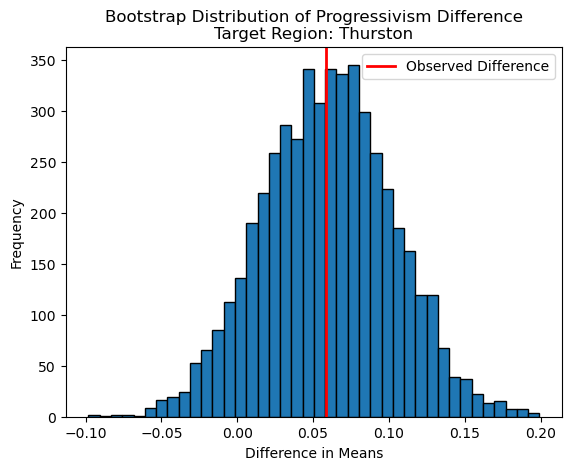

In [56]:
plt.hist(boot_diffs, bins=40, edgecolor="black")
plt.axvline(observed_diff, color="red", linewidth=2, label="Observed Difference")
plt.title(f"Bootstrap Distribution of Progressivism Difference\nTarget Region: {target_region}")
plt.xlabel("Difference in Means")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### CLT Approach

Summarize how you'll approximate the sampling distribution analytically (e.g., using SE formulas).

In [57]:

# Compute progressivism score
wsecu_survey_data['progressivism'] = (
    wsecu_survey_data[['harm', 'fair']].mean(axis=1)
    - wsecu_survey_data[['purity', 'in.group', 'authority']].mean(axis=1)
)

# Define my target region (change to your actual column value)
target_region_name = "Thurston"  

# Split into target vs. others
target = wsecu_survey_data[
    wsecu_survey_data['region'] == target_region_name
]['progressivism']

others = wsecu_survey_data[
    wsecu_survey_data['region'] != target_region_name
]['progressivism']

# Means
mean_target = target.mean()
mean_others = others.mean()

# Variances (sample variance)
var_target = target.var(ddof=1)
var_others = others.var(ddof=1)

# Sample sizes
n_target = len(target)
n_others = len(others)

# CLT Standard Error
se = np.sqrt(var_target/n_target + var_others/n_others)

# z-score
z = (mean_target - mean_others) / se

# Two-sided p-value
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

mean_target, mean_others, z, p_value


(0.9613793103448276,
 0.9030070754716981,
 1.3555286601796412,
 0.17524918368525677)

### Comparison

Discuss how the computational and CLT approaches align or diverge.

Both methods give differents P-values with the permutation of P-value .5 and the CLT has the P-value of .17. with P-vale >.05 means that the result is not statstically significant.

## Task 3

If this task is going to be a hypothesis test, briefly describe the hypothesis and dataset. If this task is going to be the calculation of an uncertainty, describe the metric and data. If this is the uncertainty calculation where you'll choose an additional metric other than the mean or a proportion, describe that metric as well.

Compare the fraction of respondents with satisfaction > 4 for one gender versus others using a permutation test on the binary “satisfaction > 4” indicator.



### Computational Approach

Outline the resampling or permutation workflow you'll use.

Compare the fraction of respondents with satisfaction > 4 for one gender versus others using a permutation test on the binary “satisfaction > 4” indicator.

In [58]:
satisf_survey=pd.read_csv('satisfaction_survey.txt', sep='\t')

# Drop missing values
satisf_survey = satisf_survey.dropna(subset=["satisfaction", "gender"])

# Create high satisfaction indicator (1 if >4)
satisf_survey["high_sat"] = (satisf_survey["satisfaction"] > 4).astype(int)

# Compare one gender vs. all others
satisf_survey["is_man"] = (satisf_survey["gender"] == "man").astype(int)


In [59]:
prop_men = satisf_survey[satisf_survey["is_man"] == 1]["high_sat"].mean()
prop_others = satisf_survey[satisf_survey["is_man"] == 0]["high_sat"].mean()

observed_diff = prop_men - prop_others
print("Observed difference:", observed_diff)


Observed difference: 0.1891312630977329


In [60]:
n_perm = 5000
perm_diffs = []

for _ in range(n_perm):
    shuffled_labels = satisf_survey["is_man"].sample(frac=1, replace=False).values
    
    diff = satisf_survey.loc[shuffled_labels == 1, "high_sat"].mean() - \
           satisf_survey.loc[shuffled_labels == 0, "high_sat"].mean()
    
    perm_diffs.append(diff)

perm_diffs = np.array(perm_diffs)


In [61]:
p_value = np.mean(np.abs(perm_diffs) >= abs(observed_diff))
print("Permutation p-value:", p_value)


Permutation p-value: 0.0012


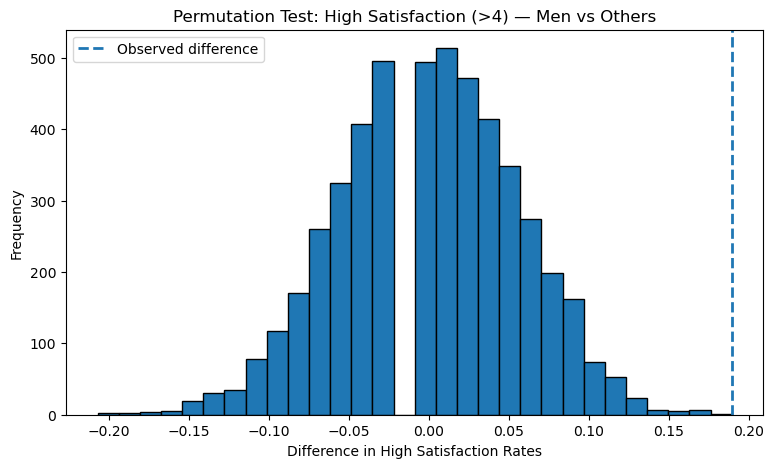

In [62]:
plt.figure(figsize=(9,5))
plt.hist(perm_diffs, bins=30, edgecolor="black")
plt.axvline(observed_diff, linestyle="--", linewidth=2)
plt.title("Permutation Test: High Satisfaction (>4) — Men vs Others")
plt.xlabel("Difference in High Satisfaction Rates")
plt.ylabel("Frequency")
plt.legend(["Observed difference"])
plt.show()


### CLT Approach

Summarize how you'll approximate the sampling distribution analytically (e.g., using SE formulas).

In [63]:
from scipy.stats import norm

#Create binary high-satisfaction indicator
satisf_survey["high_sat"] = (satisf_survey["satisfaction"] > 4).astype(int)

#Define groups
men = satisf_survey[satisf_survey["gender"] == "man"]["high_sat"]
others = satisf_survey[satisf_survey["gender"] != "man"]["high_sat"]

#Sample sizes
n1 = len(men)
n2 = len(others)

#Sample proportions
p1 = men.mean()
p2 = others.mean()

#Observed difference
obs_diff = p1 - p2

#Standard error under CLT
SE = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
#One-sided p-value (testing p1 > p2)
p_value = 1 - norm.cdf(z)

#Compute 95% CI for difference in proportions
ci_low  = obs_diff - 1.96 * SE
ci_high = obs_diff + 1.96 * SE

obs_diff, SE, z, p_value, ci_low, ci_high



(0.1891312630977329,
 0.0506576282387516,
 1.3555286601796412,
 0.08762459184262839,
 0.08984231174977977,
 0.288420214445686)

In [64]:

results_df = pd.DataFrame({
    "obs_diff": [obs_diff],
    "SE": [SE],
    "z_score": [z],
    "p_value": [p_value],
    "CI_low_95%": [ci_low],
    "CI_high_95%": [ci_high]
})

results_df

,obs_diff,SE,z_score,p_value,CI_low_95%,CI_high_95%
0,0.189131,0.050658,1.355529,0.087625,0.089842,0.28842


### Comparison

Discuss how the computational and CLT approaches align or diverge.

The permutation and Central Limit Theorem (CLT) confidence showed a strong evidence that mean satisfaction differ across gender groups, but they rely on different assumptions.

## Task 4

If this task is going to be a hypothesis test, briefly describe the hypothesis and dataset. If this task is going to be the calculation of an uncertainty, describe the metric and data. If this is the uncertainty calculation where you'll choose an additional metric other than the mean or a proportion, describe that metric as well.

Generate bootstrap CIs for mean satisfaction within each gender group to quantify uncertainty around the observed differences.



### Computational Approach

Outline the resampling or permutation workflow you'll use.

In [65]:
# Bootstrap function 
def bootstrap_mean(series, n_boot=5000):
    """Return bootstrap distribution of means for a given series."""
    boot_means = []
    for _ in range(n_boot):
        sample = series.sample(frac=1, replace=True)
        boot_means.append(sample.mean())
    return np.array(boot_means)
# Generate Central Interval by gender 
results = []

for gender, group in satisf_survey.groupby("gender"):
    boot = bootstrap_mean(group["satisfaction"])
    mean_val = group["satisfaction"].mean()
    ci_low, ci_high = np.quantile(boot, [0.025, 0.975])
    
    results.append({
        "gender": gender,
        "mean_satisfaction": mean_val,
        "CI_low_95%": ci_low,
        "CI_high_95%": ci_high
    })

# Make into a DataFrame
bootstrap_summary = pd.DataFrame(results)
print(bootstrap_summary)

    gender  mean_satisfaction  CI_low_95%  CI_high_95%
0      man           4.209945    4.055249     4.364641
1  neither           3.300000    2.900000     3.700000
2    woman           3.622642    3.424528     3.811557


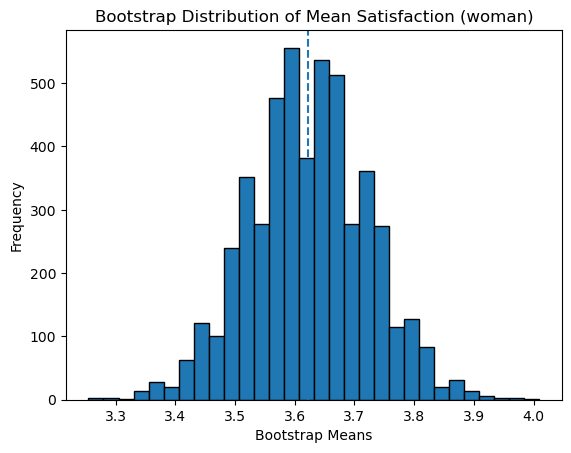

In [66]:
# Choose the gender you want to plot
gender_to_plot = "woman"

boot = bootstrap_mean(satisf_survey[satisf_survey["gender"] == gender_to_plot]["satisfaction"])

plt.hist(boot, bins=30, edgecolor="black")
plt.title(f"Bootstrap Distribution of Mean Satisfaction ({gender_to_plot})")
plt.xlabel("Bootstrap Means")
plt.ylabel("Frequency")
plt.axvline(np.mean(boot), linestyle="--")
plt.show()


### CLT Approach

Summarize how you'll approximate the sampling distribution analytically (e.g., using SE formulas).

In [67]:
# Function for CLT CI
def clt_ci(series, level=0.95):
    mean = series.mean()
    sd = series.std(ddof=1)
    n = series.shape[0]
    
    z = 1.96  # 95% CI
    se = sd / np.sqrt(n)
    
    ci_low = mean - z * se
    ci_high = mean + z * se
    
    return mean, ci_low, ci_high, n, se

In [68]:
# Compute CLT CI for each gender
results = []

for gender, group in satisf_survey.groupby("gender"):
    mean, low, high, n, se = clt_ci(group["satisfaction"])
    results.append({
        "gender": gender,
        "sample_size": n,
        "mean_satisfaction": mean,
        "SE": se,
        "CI_low_95%": low,
        "CI_high_95%": high
    })

clt_summary = pd.DataFrame(results)
print(clt_summary)

    gender  sample_size  mean_satisfaction        SE  CI_low_95%  CI_high_95%
0      man          181           4.209945  0.081050    4.051086     4.368803
1  neither           10           3.300000  0.213437    2.881663     3.718337
2    woman          106           3.622642  0.099823    3.426989     3.818294


### Comparison

Discuss how the computational and CLT approaches align or diverge.

The bootstrap and Central Limit Theorem (CLT) confidence intervals both estimate uncertainty in mean satisfaction across gender groups, but they rely on different assumptions. When comparing both the man's CI_low_95% and CI_high_95% are respectively 4.051086 and 4.368803 and for woman,s CI_low_95% and CI_high_95% are respectively 3.426989 and 3.818294 both gave very similar result, meaning mainingful differences in average satistifaction accross gender groups.

## Task 5

If this task is going to be a hypothesis test, briefly describe the hypothesis and dataset. If this task is going to be the calculation of an uncertainty, describe the metric and data. If this is the uncertainty calculation where you'll choose an additional metric other than the mean or a proportion, describe that metric as well.  

### Computational Approach

Outline the resampling or permutation workflow you'll use.

Build 95% CIs for F-150 prices in each city by sampling within location (or using bootstrap) so students can compare price uncertainty geographically.

In [69]:
car_listings = pd.read_csv('car_listings.zip')
car_listings.head()

,url,location,post_id,time_posted,name,make,model,year,odometer,title,...,type,transmission,condition,vin,price,posting_body_text,title_text,num_images,latitude,longitude
0,https://fargo.craigslist.org/cto/d/west-fargo-...,fargo,7787882335,2024-09-25 09:35:39+00:00,chevy equinox lt awd,chevrolet,equinox,2013.0,160000.0,clean,...,SUV,automatic,NaN,NaN,6000.0,\n\nQR Code Link to This Post\n\n\n14 Equinox ...,14 Chevy Equinox,11.0,46.890700,-96.925800
1,https://chicago.craigslist.org/nwc/cto/d/des-p...,chicago,7789338453,2024-09-30 12:25:28+00:00,ford transit,ford,transit 250 van,2019.0,93000.0,clean,...,van,automatic,good,NaN,21900.0,\n\nQR Code Link to This Post\n\n\n2019 Ford C...,2019 FORD TRANSIT 250 VAN,14.0,42.023580,-87.902577
2,https://chicago.craigslist.org/nch/cto/d/evans...,chicago,7789384937,2024-09-30 14:33:58+00:00,ford escape titanium,ford,escape,2014.0,122000.0,clean,...,SUV,automatic,excellent,NaN,6250.0,\n\nQR Code Link to This Post\n\n\n2014 Ford E...,2014 Ford Escape (Excellent condition) Titaniu...,12.0,42.052098,-87.686005
3,https://chicago.craigslist.org/sox/cto/d/chica...,chicago,7789321782,2024-09-30 11:42:21+00:00,nissan altima 2.5 s,nissan,altima,2015.0,145000.0,clean,...,sedan,automatic,excellent,NaN,5200.0,\n\nQR Code Link to This Post\n\n\nHeres is my...,"2015 Nissan Altima S, 145k, *Remote Start*, 4 ...",11.0,41.781400,-87.770500
4,https://chicago.craigslist.org/nwi/cto/d/scher...,chicago,7789402919,2024-09-30 15:25:31+00:00,honda odyssey touring,honda,odyssey,2007.0,230000.0,clean,...,minivan,automatic,excellent,NaN,3500.0,\n\nQR Code Link to This Post\n\n\nVery Nice V...,2007 Honda Odyssey Touring,10.0,41.492200,-87.460500


In [70]:

# 1. Filter to Ford F-150 listings
f150 = car_listings[
    (car_listings["make"].str.lower() == "ford") &
    (car_listings["model"].str.lower().str.contains("f150"))
].copy()

# 2. Function to bootstrap 95% CI for mean
def bootstrap_ci(data, n_boot=5000, seed=42):
    rng = np.random.default_rng(seed)
    boot_means = []

    for _ in range(n_boot):
        sample = rng.choice(data, size=len(data), replace=True)
        boot_means.append(sample.mean())

    # 95% CI
    low, high = np.percentile(boot_means, [2.5, 97.5])
    return boot_means, low, high

# 3. Build CI for each city
results = []

for city, group in f150.groupby("location"):
    prices = group["price"].dropna().values
    
    if len(prices) < 5:
        # too small to trust but still compute
        print(f"⚠️ Small sample in {city} (n={len(prices)}) — CI will be wide.")
    
    boot_means, ci_low, ci_high = bootstrap_ci(prices)

    results.append({
        "city": city,
        "n": len(prices),
        "mean_price": prices.mean(),
        "ci_low_95": ci_low,
        "ci_high_95": ci_high
    })

# 4. Convert to dataframe
ci_df = pd.DataFrame(results).sort_values("mean_price", ascending=False)
ci_df


,city,n,mean_price,ci_low_95,ci_high_95
3,duluth,349,14239.303725,12701.383023,15876.376361
4,fargo,230,12685.213043,11283.342391,14306.016304
2,desmoines,340,12610.820588,11360.002941,13908.010735
6,kansascity,921,12032.975027,11377.275054,12714.815119
10,omaha,390,11606.184615,10597.536987,12701.305128
0,appleton,268,11548.492537,10490.358396,12691.590951
5,grandrapids,327,11297.559633,10180.769113,12512.477141
9,minneapolis,1797,10506.069560,10054.209418,10989.647524
7,madison,355,10499.261972,9564.523944,11479.508944
11,stlouis,884,10473.903846,9821.280713,11135.937500


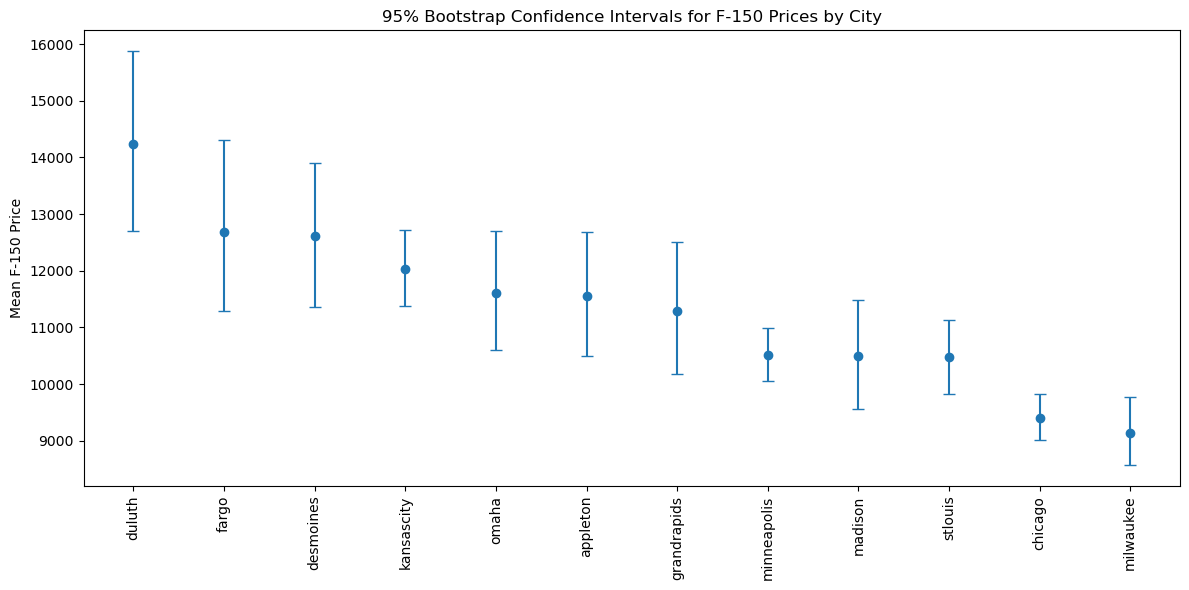

In [71]:


plt.figure(figsize=(12,6))
x = range(len(ci_df))

plt.errorbar(
    x,
    ci_df["mean_price"],
    yerr=[ci_df["mean_price"] - ci_df["ci_low_95"], 
          ci_df["ci_high_95"] - ci_df["mean_price"]],
    fmt='o',
    capsize=4
)

plt.xticks(x, ci_df["city"], rotation=90)
plt.ylabel("Mean F-150 Price")
plt.title("95% Bootstrap Confidence Intervals for F-150 Prices by City")
plt.tight_layout()
plt.show()


In [72]:
# Your code here

### CLT Approach

Summarize how you'll approximate the sampling distribution analytically (e.g., using SE formulas).

In [73]:


# Filter dataset to Ford F-150 only
f150 = car_listings[
    (car_listings["make"].str.lower() == "ford") &
    (car_listings["model"].str.lower().str.contains("f150"))
].copy()

#2. Function to compute CLT CI ---
def clt_ci(data):
    n = len(data)
    mean = np.mean(data)
    se = np.std(data, ddof=1) / np.sqrt(n)   # Standard Error
    ci_low = mean - 1.96 * se
    ci_high = mean + 1.96 * se
    return mean, se, ci_low, ci_high

#3. Apply CLT CI to each city
clt_results = []

for city, group in f150.groupby("location"):
    prices = group["price"].dropna().values

    if len(prices) < 5:
        print(f"⚠️ Warning: Very small sample size in {city} (n={len(prices)}). CLT may be unreliable.")

    mean, se, low, high = clt_ci(prices)

    clt_results.append({
        "city": city,
        "n": len(prices),
        "mean_price": mean,
        "SE": se,
        "CLT_low_95": low,
        "CLT_high_95": high
    })

clt_df = pd.DataFrame(clt_results).sort_values("mean_price", ascending=False)

clt_df


,city,n,mean_price,SE,CLT_low_95,CLT_high_95
3,duluth,349,14239.303725,821.152083,12629.845643,15848.761807
4,fargo,230,12685.213043,763.840660,11188.085350,14182.340737
2,desmoines,340,12610.820588,666.071388,11305.320667,13916.320509
6,kansascity,921,12032.975027,343.631585,11359.457120,12706.492934
10,omaha,390,11606.184615,532.677728,10562.136268,12650.232963
0,appleton,268,11548.492537,562.109114,10446.758674,12650.226400
5,grandrapids,327,11297.559633,604.425514,10112.885625,12482.233641
9,minneapolis,1797,10506.069560,237.458930,10040.650058,10971.489063
7,madison,355,10499.261972,479.877673,9558.701733,11439.822211
11,stlouis,884,10473.903846,328.576942,9829.893040,11117.914652


### Comparison

Discuss how the computational and CLT approaches align or diverge.

In [74]:
comparison = clt_df.merge(ci_df, on="city", suffixes=("_CLT", "_BOOT"))
comparison


,city,n_CLT,mean_price_CLT,SE,CLT_low_95,CLT_high_95,n_BOOT,mean_price_BOOT,ci_low_95,ci_high_95
0,duluth,349,14239.303725,821.152083,12629.845643,15848.761807,349,14239.303725,12701.383023,15876.376361
1,fargo,230,12685.213043,763.840660,11188.085350,14182.340737,230,12685.213043,11283.342391,14306.016304
2,desmoines,340,12610.820588,666.071388,11305.320667,13916.320509,340,12610.820588,11360.002941,13908.010735
3,kansascity,921,12032.975027,343.631585,11359.457120,12706.492934,921,12032.975027,11377.275054,12714.815119
4,omaha,390,11606.184615,532.677728,10562.136268,12650.232963,390,11606.184615,10597.536987,12701.305128
5,appleton,268,11548.492537,562.109114,10446.758674,12650.226400,268,11548.492537,10490.358396,12691.590951
6,grandrapids,327,11297.559633,604.425514,10112.885625,12482.233641,327,11297.559633,10180.769113,12512.477141
7,minneapolis,1797,10506.069560,237.458930,10040.650058,10971.489063,1797,10506.069560,10054.209418,10989.647524
8,madison,355,10499.261972,479.877673,9558.701733,11439.822211,355,10499.261972,9564.523944,11479.508944
9,stlouis,884,10473.903846,328.576942,9829.893040,11117.914652,884,10473.903846,9821.280713,11135.937500


The bootstrap and Central Limit Theorem (CLT) confidence intervals both estimate uncertainty in F150 in each city, but they rely on different assumptions.By comparaison CLT and bootstraping methods, even though they are difference, we can say we are 95%v confident that the true average price in dulth is betweeen $12701-$15876.

## Reflection

- Having done these analyses in two ways, what are your thoughts on the process?
- It's Prof. Chandler's contention that doing computational approaches is better because it gues you in touch with the details of the null hypothesis and where the p-value comes from. How does it seem to you? (To be clear, feel _free_ to disagree with me!)
- To what extent did you find an interesting additional metric to do bootstrapping on? In other words, for the metric you chose that _wasn't_ a proportion or mean, is that metric interesting? If it is, say why and tell me how hard it was to come up with. If not, tell me why it was hard for you to come up with a metric that was intrinsically interesting. 


#### Write your reflection below here



Having done these analysis in two ways, was valuable because it highlighted how different inferential frameworks can lead to the same conclusion while relying on different methods. I feel like many questions in data analysis are framed around calculating averages, so moving beyoind that frame by using metrics like median, interquartile range, difference between upper and lower quantiles is very interesting because it captures mores variability, robustness.